In [85]:
import json, requests, sys

endpoint = "https://api.millercenter.org/speeches"
out_file = "speeches.json"

r = requests.post(url=endpoint)
data = r.json()
items = data['Items']

while 'LastEvaluatedKey' in data:
    parameters = {"LastEvaluatedKey": data['LastEvaluatedKey']['doc_name']}
    r = requests.post(url = endpoint, params = parameters)
    data = r.json()
    items += data['Items']
    print(f'{len(items)} speeches')

with open(out_file, "w") as out:
    out.write(json.dumps(items))
    print(f'wrote results to file: {out_file}')

ModuleNotFoundError: No module named 'requests'

In [ ]:
import json
import pandas as pd

# Load JSON file
with open('speeches.json', 'r') as file:
    speeches_data = json.load(file)

# Convert to DataFrame for easier handling
df = pd.DataFrame(speeches_data)

# Extract relevant fields
texts = df['transcript']

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Transform the transcripts into TF-IDF vectors
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(tfidf_matrix)

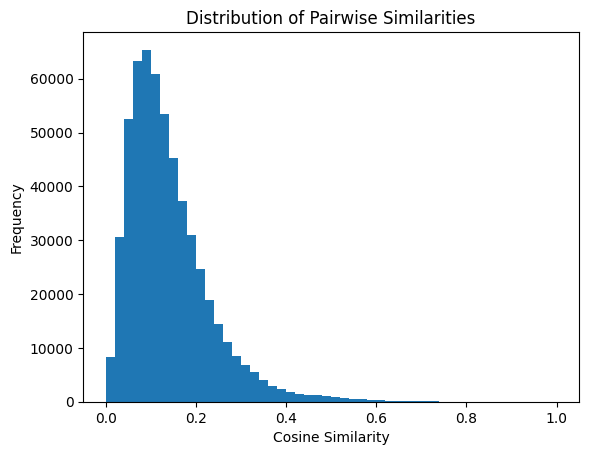

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten the similarity matrix to get all pairwise similarity scores
similarities = similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)]

# Plot a histogram of similarity scores
plt.hist(similarities, bins=50)
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Pairwise Similarities')
plt.show()


Number of nodes: 1057
Number of edges: 952


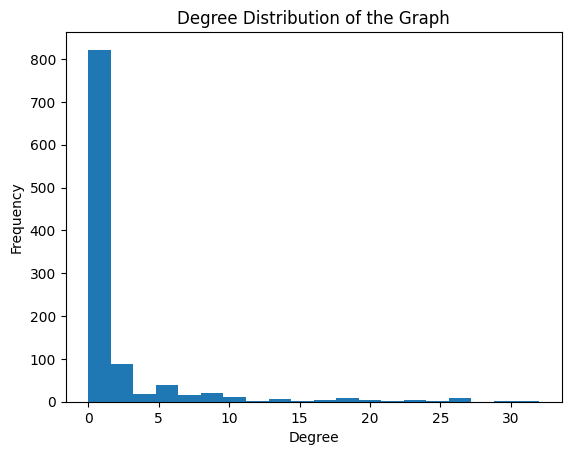

In [133]:
import networkx as nx

# Initialize the graph
G = nx.Graph()

# Define a threshold for creating edges
threshold = 0.6


# Add nodes and edges
for i in range(len(df)):
    # Add each speech as a node with its title
    G.add_node(i, title=df.loc[i, 'title'], date=df.loc[i, 'date'], president=df.loc[i, 'president'])

# Iterate over the similarity matrix and add edges based on the threshold
for i in range(len(df)):
    for j in range(i+1, len(df)):
        if similarity_matrix[i, j] > threshold:
            G.add_edge(i, j, weight=similarity_matrix[i, j])

# Print the number of nodes and edges in the graph
print(f'Number of nodes: {G.number_of_nodes()}')
print(f'Number of edges: {G.number_of_edges()}')

# Print degree distribution
degrees = [val for (node, val) in G.degree()]
plt.hist(degrees, bins=20)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution of the Graph')
plt.show()

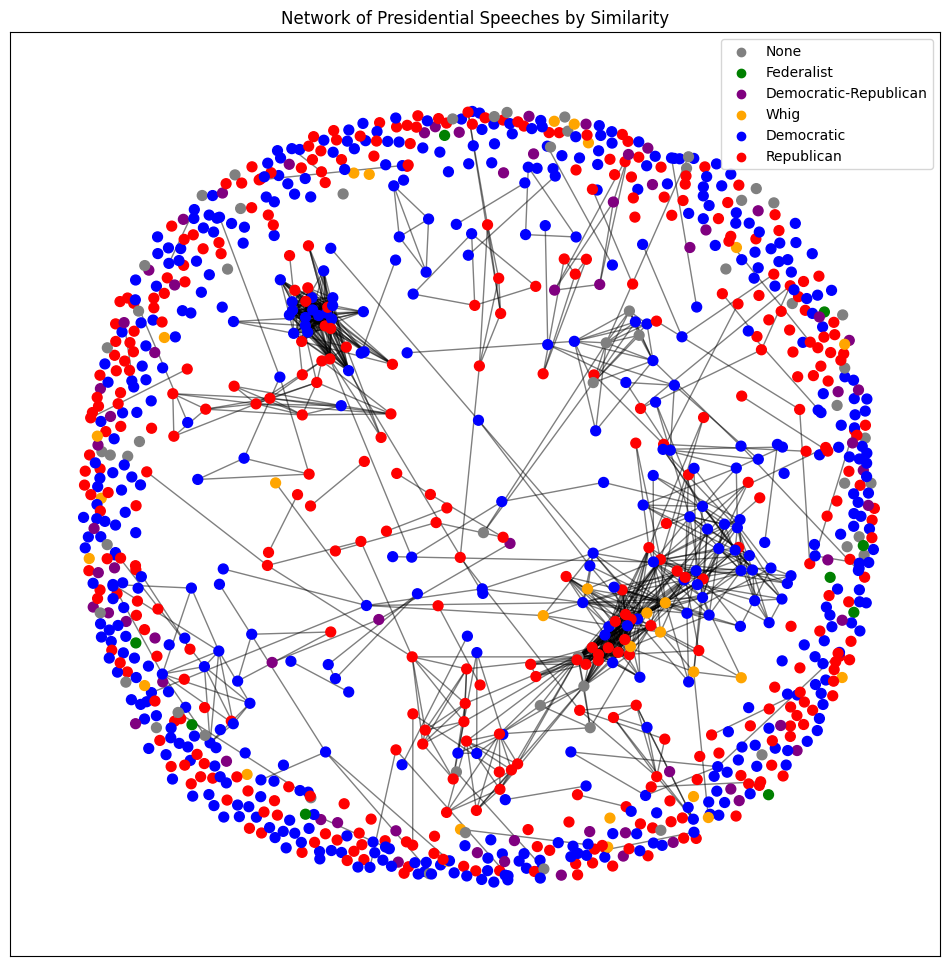

In [134]:
import matplotlib.pyplot as plt
from parties import president_party, party_colors

# Draw the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.2)

node_colors = []
for node in G.nodes():
    president = G.nodes[node]['president']
    party = president_party.get(president, "None")  # Get party or default to "None"
    color = party_colors.get(party, "gray")  # Get color based on party
    node_colors.append(color)

# Draw nodes and edges with labels
nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_colors)
nx.draw_networkx_edges(G, pos, alpha=0.5)
# nx.draw_networkx_labels(G, pos, {i: G.nodes[i]['title'] for i in G.nodes}, font_size=8)

for party, color in party_colors.items():
    plt.scatter([], [], c=color, label=party)
plt.legend(scatterpoints=1, loc='best')

plt.title('Network of Presidential Speeches by Similarity')
plt.show()


In [135]:
# Get the largest communities with more than 1 node
communities = [c for c in nx.connected_components(G) if len(c) > 1]

# Sort the communities by size
communities = sorted(communities, key=len, reverse=True)

#top 5 communities
top_communities = communities[:5]

# Print the size of the top 5 communities
for i, community in enumerate(top_communities):
    print(f'Community {i+1}: {len(community)} nodes')

Community 1: 98 nodes
Community 2: 60 nodes
Community 3: 14 nodes
Community 4: 13 nodes
Community 5: 9 nodes


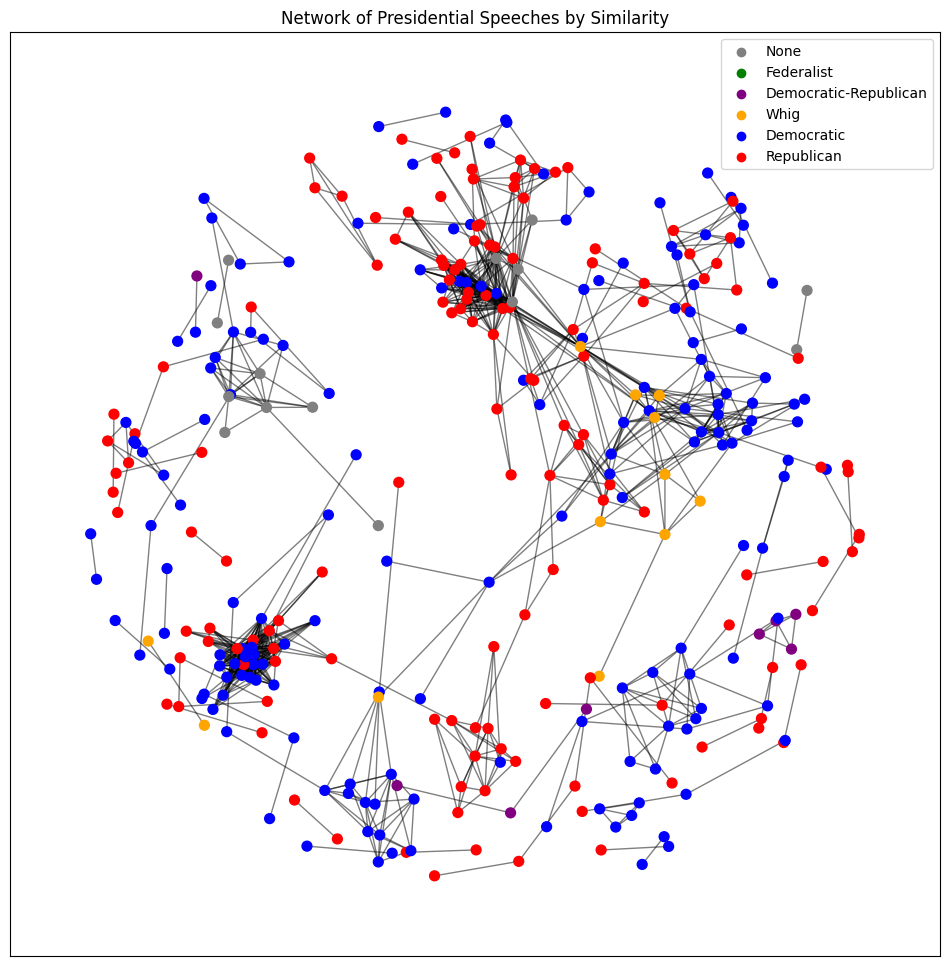

In [136]:
#Remove isolated nodes
G.remove_nodes_from(list(nx.isolates(G)))

#Draw the graph

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.2)

node_colors = []
for node in G.nodes():
    president = G.nodes[node]['president']
    party = president_party.get(president, "None")  # Get party or default to "None"
    color = party_colors.get(party, "gray")  # Get color based on party
    node_colors.append(color)

# Draw nodes and edges with labels
nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_colors)
nx.draw_networkx_edges(G, pos, alpha=0.5)
# nx.draw_networkx_labels(G, pos, {i: G.nodes[i]['title'] for i in G.nodes}, font_size=8)

for party, color in party_colors.items():
    plt.scatter([], [], c=color, label=party)
plt.legend(scatterpoints=1, loc='best')

plt.title('Network of Presidential Speeches by Similarity')
plt.show()

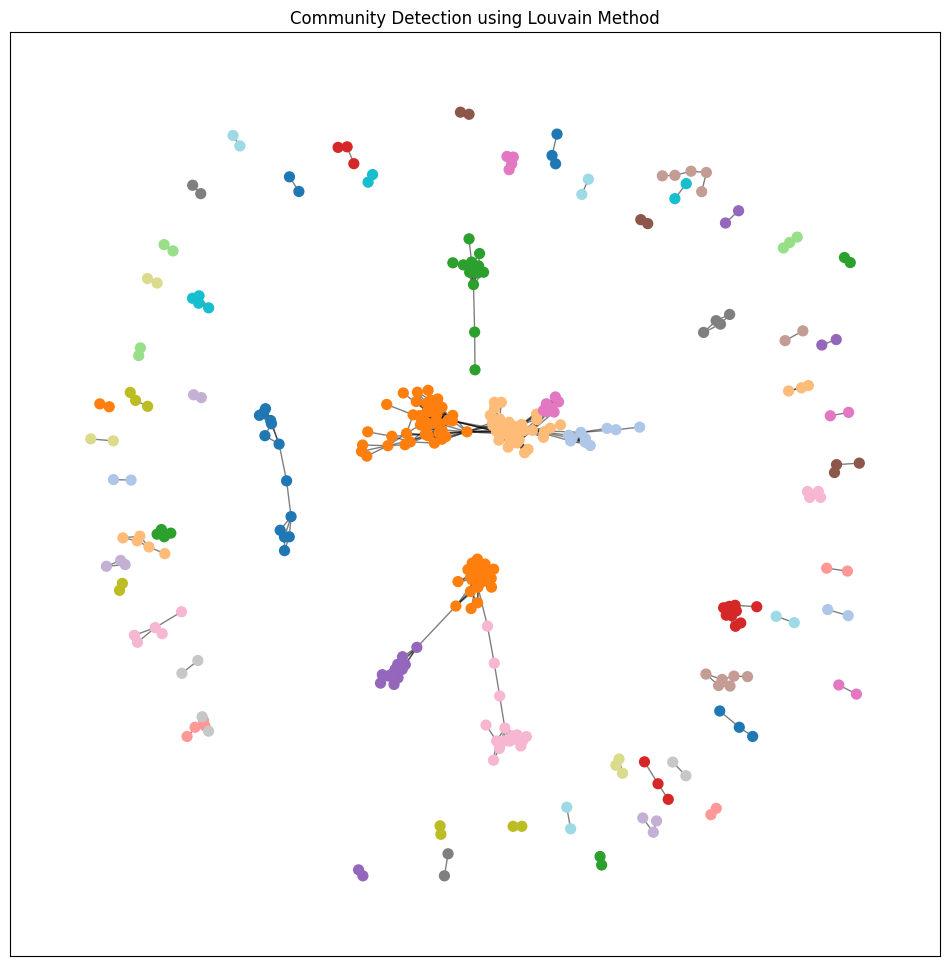

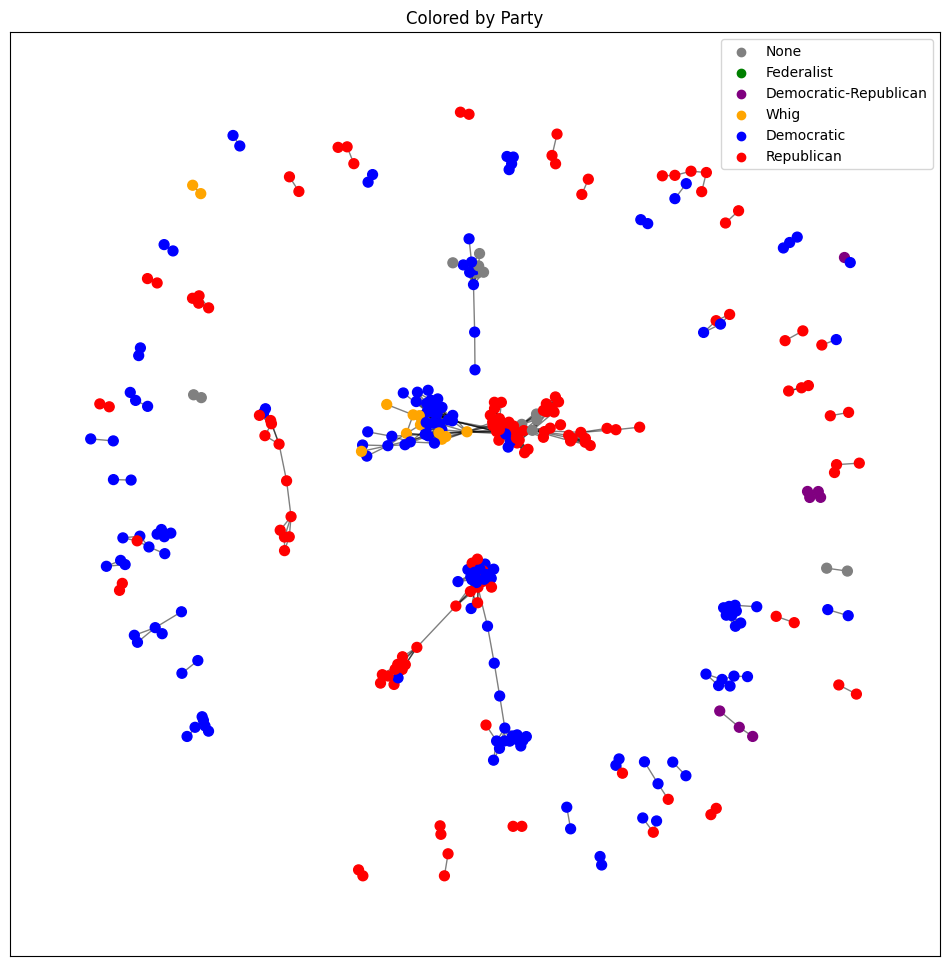

In [138]:
import community as community_louvain  # Install via `pip install python-louvain`

#Remove nodes with no community
G.remove_nodes_from(list(nx.isolates(G)))

# Detect communities using the Louvain method
partition = community_louvain.best_partition(G)

# `partition` is a dictionary where keys are nodes and values are community ids
for node, community_id in partition.items():
    G.nodes[node]['community'] = community_id

# Set color for each community
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 12))

# Draw nodes with colors representing communities
nx.draw_networkx_nodes(G, pos, node_color=list(partition.values()), node_size=50, cmap=plt.cm.tab20)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title('Community Detection using Louvain Method')
plt.show()

plt.figure(figsize=(12, 12))

party_node_colors = []
for node in G.nodes():
    president = G.nodes[node]['president']
    party = president_party.get(president, "None")  # Get party or default to "None"
    color = party_colors.get(party, "gray")  # Get color based on party
    party_node_colors.append(color)

# Draw nodes with colors representing communities
nx.draw_networkx_nodes(G, pos, node_color=party_node_colors, node_size=50, cmap=plt.cm.tab20)
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Add legend for party colors
for party, color in party_colors.items():
    plt.scatter([], [], c=color, label=party)
plt.legend(scatterpoints=1, loc='best')

plt.title('Colored by Party')
plt.show()